### Code used for single cell data analysis and generation of anndata object
_Single cell RNA Sequencing Identifies G-protein Coupled Receptor 87 as a Novel Basal Cell Marker of Distal Honeycomb Cysts in IPF_  
Katharina Heinzelmann, Qianjiang Hu, Yan Hu, et al. and Mareike Lehmann, Melanie Königshoff

In [1]:
## Load Libraries 
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import scrublet as scr
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

## Plotting Parameters
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
sb.set_style("ticks")

## Set Filepaths
dge_path = "./ipf/data/"
out_folder = "./ipf/output/"
object_folder = "./ipf/object/"

sc.logging.print_version_and_date()

Running Scanpy 1.8.0, on 2021-10-20 12:29.


In [2]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(SoupX))
suppressPackageStartupMessages(library(Matrix))

### Read in count matrices

In [4]:
samples = ["LTC22", "LTC34", "LTC52", "LTC46", "LTC55", "LTC50"]
files = ["%s.h5" %s for s in samples]
grouping = pd.read_csv(out_folder + "ipf_samples_info.txt", sep = '\t', header = (0), index_col = 0)
grouping

,internal_id,smoke_status,health_status,age_status,age,gender,cells
Koenigshoff_07122018,LTC22,smoker,IPF,IPF,45,male,10000
LTC34,LTC34,non-smoker,IPF,IPF,64,male,10000
MKIPFLTC52,LTC52,non-smoker,IPF,IPF,68,female,10000
Koenigshoff_02152019,LTC46,non-smoker,healthy,old,66,male,10000
MKdonor55,LTC55,non-smoker,healthy,old,68,female,10000
MKdonorLTC50,LTC50,non-smoker,healthy,old,66,male,10000


In [5]:
def read_dges_10x(files):
    adatas = []
    
    for file in files:
        sample = file.replace(".h5", "")
        print("Reading DGE for sample %s" %(sample))
        a = sc.read_10x_h5(dge_path + file)
        a.var_names_make_unique()
        del(a.var)

        ## Add all columns from Grouping Table as Metainfo
        for col in np.setdiff1d(grouping.columns, "cells"):
            a.obs[col] = grouping.loc[sample, col]
            
        a.obs_names = ["%s_%s" %(sample, cell.replace("-1", "")) for cell in a.obs_names.values]
        adatas.append(a)
        
    return adatas

In [6]:
adatas = read_dges_10x(files)
adata = adatas[0].concatenate(adatas[1:], batch_key = "identifier", join = "outer", index_unique = None)  
adata.obs["identifier"].cat.categories = samples

## 
adata.X = np.nan_to_num(adata.X)
adata.X = adata.X.toarray()
adata

Reading DGE for sample Koenigshoff_07122018


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample LTC34


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKIPFLTC52


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample Koenigshoff_02152019


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKdonor55


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKdonorLTC50


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 58116 × 20631
    obs: 'age', 'age_status', 'gender', 'health_status', 'internal_id', 'smoke_status', 'identifier'

### Preprocessing and Quality Control


In [7]:
# Quality control - calculate QC Metrics
mt_genes = [gene.startswith("MT-") for gene in adata.var_names]
adata.obs["n_counts"] = adata.X.sum(1)         
adata.obs["n_genes"] = (adata.X > 0).sum(1)
adata.obs["percent_mito"] = adata.X[:, mt_genes].sum(1) / adata.obs["n_counts"]

adata.X = sparse.csr_matrix(adata.X)

### Quality control - plot QC Metrics

... storing 'age_status' as categorical
... storing 'gender' as categorical
... storing 'health_status' as categorical
... storing 'internal_id' as categorical
... storing 'smoke_status' as categorical


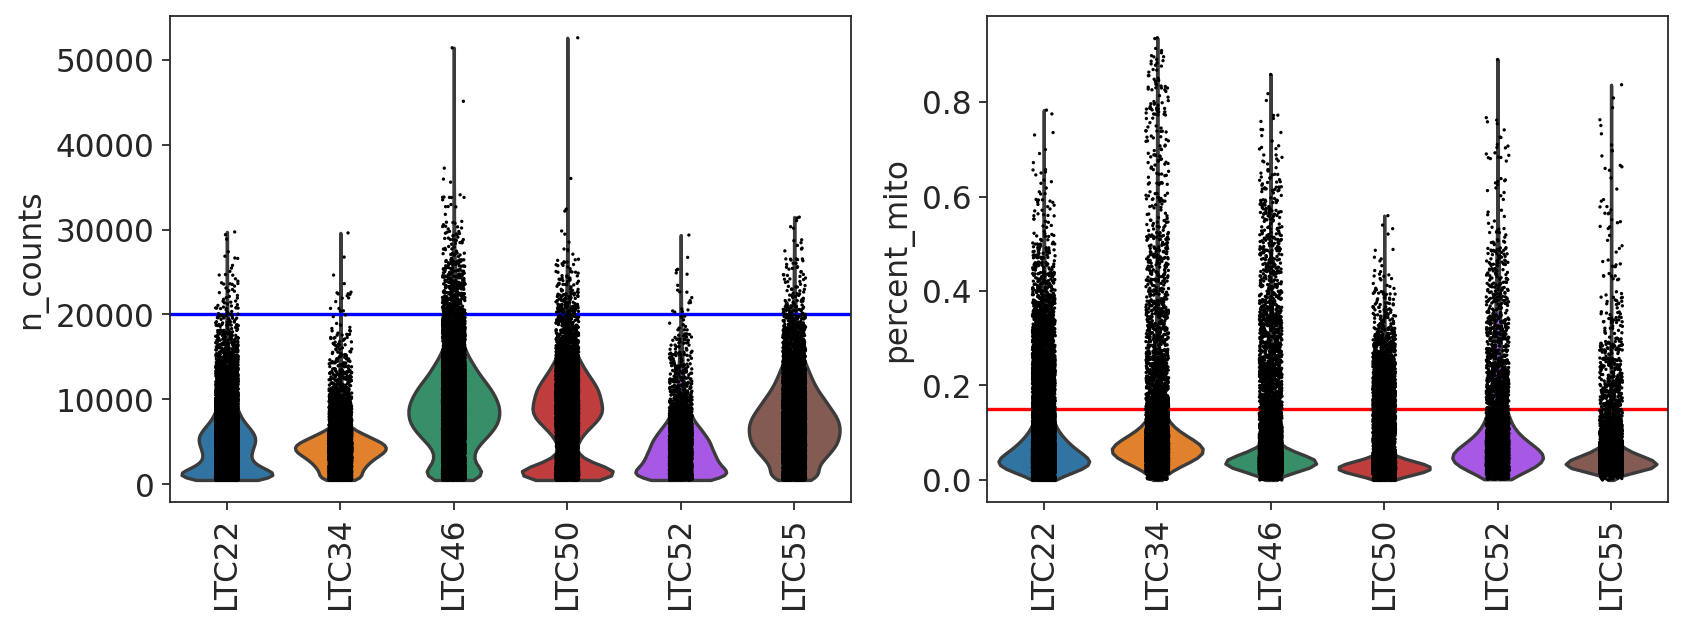

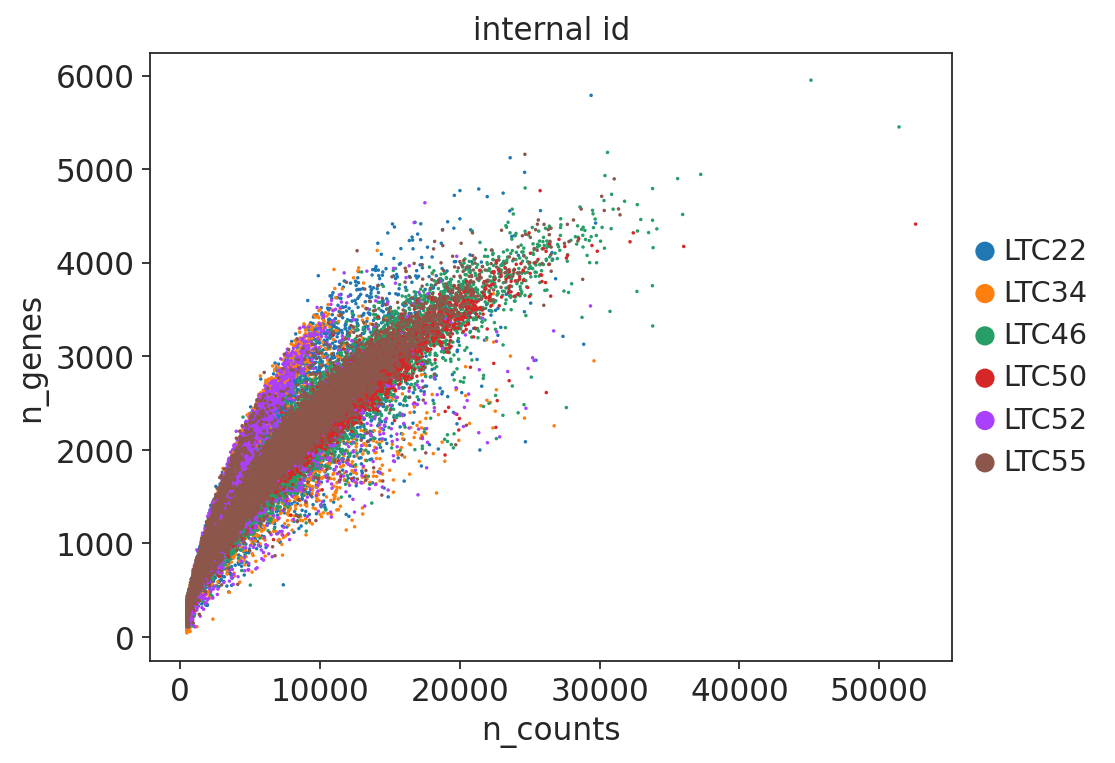

In [8]:
group = "internal_id"
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
axs = axs.ravel()

sc.pl.violin(adata, "n_counts", groupby = group, size = 1.5, rotation = 90, show = False, ax = axs[0])
sc.pl.violin(adata, "percent_mito", groupby = group, size = 1.5, rotation = 90, show = False, ax = axs[1])
axs[0].axhline(20000, color = "blue")
axs[1].axhline(0.15, color = "red")
plt.show()

sc.pl.scatter(adata, "n_counts", "n_genes", color = group, size = 10)

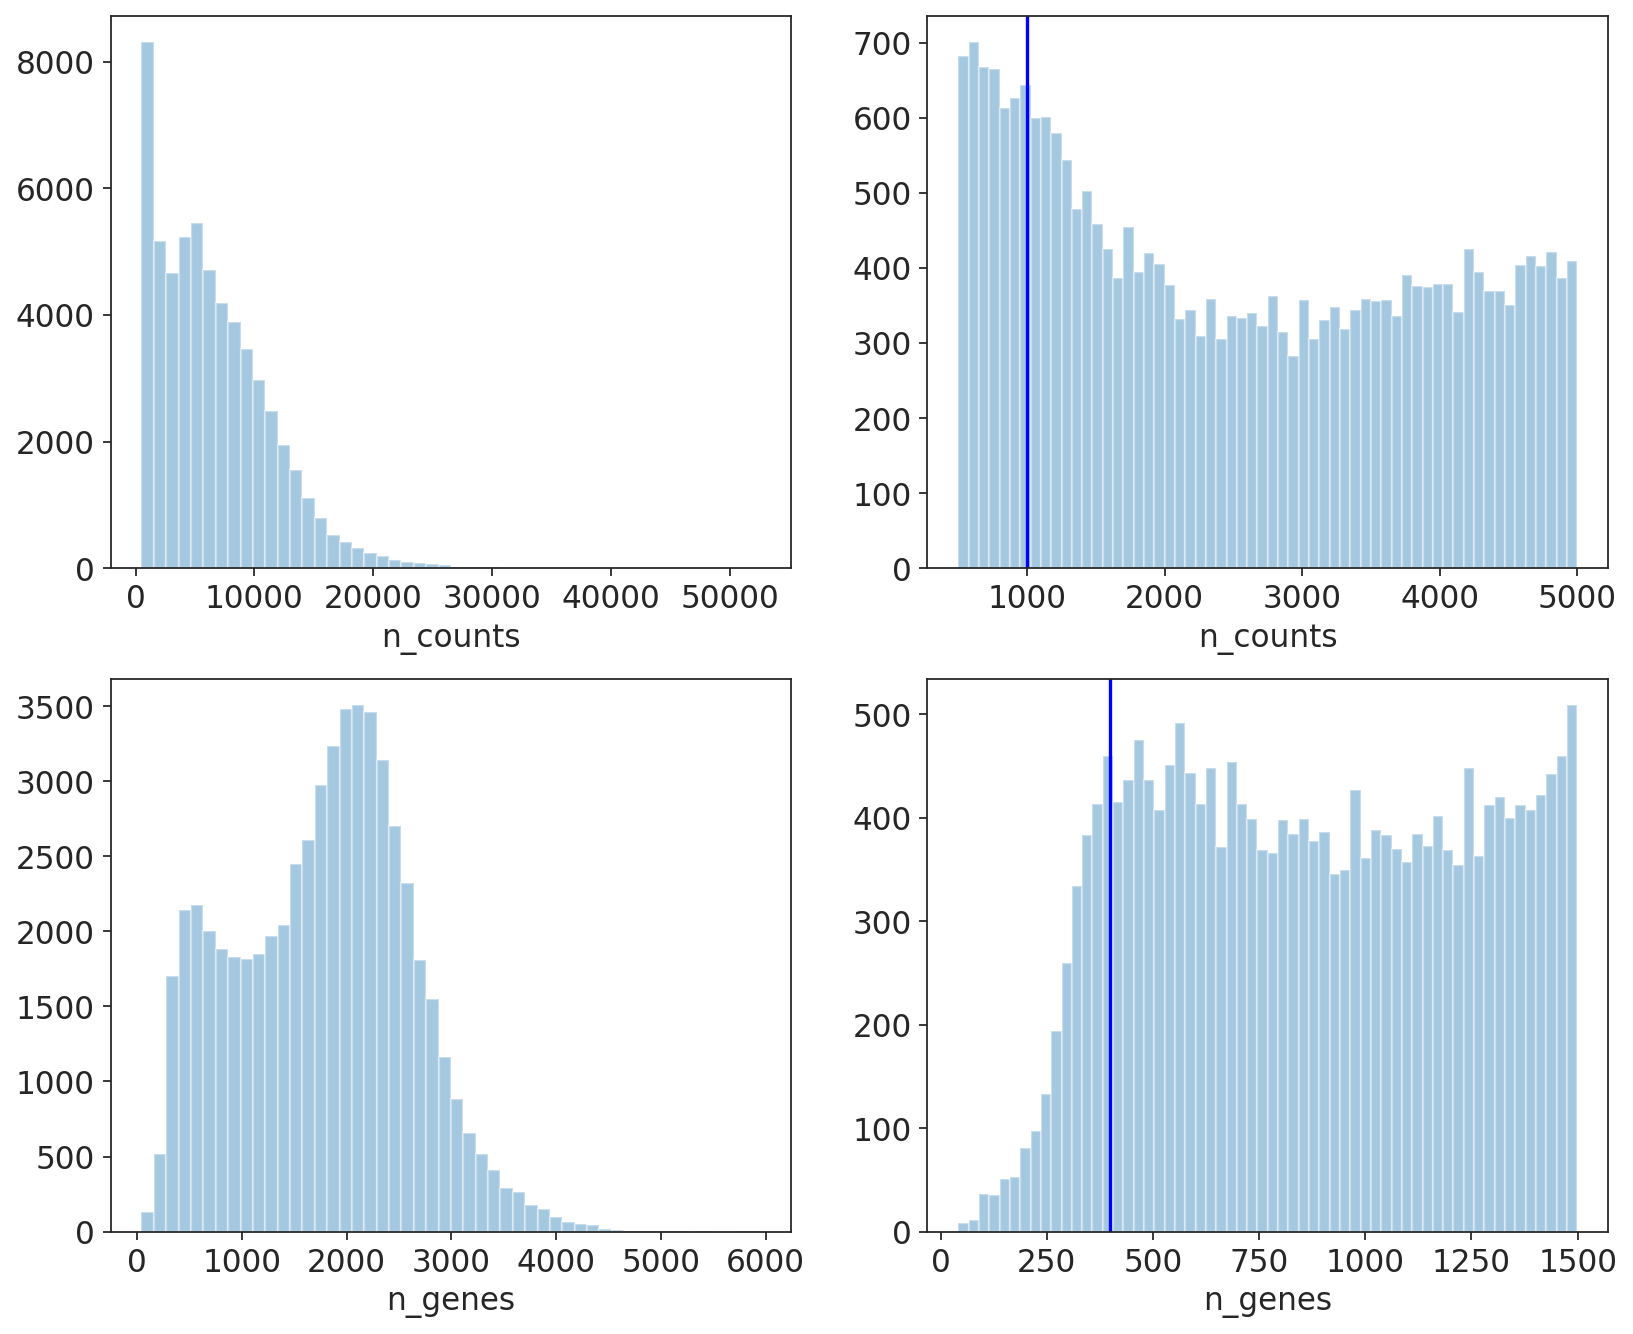

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
axs = axs.ravel()

sb.distplot(adata.obs['n_counts'], kde = False, ax = axs[0])
sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < 5000], kde = False, bins = 60, ax = axs[1])
sb.distplot(adata.obs['n_genes'], kde = False, ax = axs[2])
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < 1500], kde = False, bins = 60, ax = axs[3])

axs[1].axvline(1000, color = "blue")
axs[3].axvline(400, color = "blue")
plt.show()

#### Actually do the filtering

In [10]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_genes(adata, min_cells = 3)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs["percent_mito"] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 58116
Number of cells after max count filter: 53761
Number of cells after max count filter: 52981
Number of cells after min count filter: 52896
Number of cells after gene filter: 52896
Number of cells after MT filter: 47938


### Summary Statistics after Filtering

In [11]:
group = "internal_id"
info = pd.DataFrame(data = adata.obs.identifier.cat.categories, columns = ["identifier"])
info[group] = grouping.loc[info.identifier.values].loc[:, group].values
info["n_counts"] = adata.obs.groupby(["identifier"])["n_counts"].median().values
info["n_genes"] = adata.obs.groupby(["identifier"])["n_genes"].median().values
info["percent_mito"] = adata.obs.groupby(["identifier"])["percent_mito"].mean().values
info["n_cells"] = adata.obs.groupby(["identifier"])["n_genes"].size().values
info

,identifier,internal_id,n_counts,n_genes,percent_mito,n_cells
0,Koenigshoff_07122018,LTC22,5481.0,1826.0,0.056809,9466
1,LTC34,LTC34,4419.0,1809.0,0.069366,7551
2,MKIPFLTC52,LTC52,4669.5,1783.5,0.061964,2954
3,Koenigshoff_02152019,LTC46,9070.0,2216.0,0.045359,10915
4,MKdonor55,LTC55,7228.0,1983.5,0.043269,9082
5,MKdonorLTC50,LTC50,9180.0,2177.5,0.038033,7970


### Doublet Detection with Scrublet (sample-wise)

In [12]:
ids = adata.obs.identifier.cat.categories
adata.obs["doublet_scores"] = np.nan

for i, cur_id in enumerate(ids):
    sub = adata[adata.obs.identifier == cur_id].copy()

    ## Input: raw (unnormalized) UMI counts matrix counts_matrix with cells as rows and genes as columns
    print("%s\tCalculating doublet score for %s" %(i, cur_id))
    scrub = scr.Scrublet(sub.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose = False)
    doublet_scores = pd.DataFrame(doublet_scores, index = sub.obs_names, columns = ["doublet_scores"])
    adata.obs["doublet_scores"].update(doublet_scores.doublet_scores)
    

Trying to set attribute `.obs` of view, copying.


0	Calculating doublet score for Koenigshoff_07122018
1	Calculating doublet score for LTC34
2	Calculating doublet score for MKIPFLTC52
3	Calculating doublet score for Koenigshoff_02152019
4	Calculating doublet score for MKdonor55
5	Calculating doublet score for MKdonorLTC50


### Ambient gene removal with SoupX and normalization with Scran

In [13]:
%%R

soup_counts <- function(data, cells, genes, soupx_groups){
    print(dim(data))
    rownames(data) = genes
    colnames(data) = cells
    data <- as(data, "sparseMatrix")
    
    ## Generate SoupChannel Object for SoupX
    sc = SoupChannel(data, data, calcSoupProfile = FALSE)
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    sc = setClusters(sc, soupx_groups)

    ## Set the Contamination Fraction manually
    print(paste("Started SoupX", Sys.time()))
    sc = setContaminationFraction(sc, 0.3)
    out = adjustCounts(sc, roundToInt = TRUE)
    print(paste("Finished SoupX", Sys.time()))
    return(out)
}

get_size_factors <- function(out, scran_groups){
    ## Input souped count matrix directly to Scran
    print(paste("Started Size Factor Calculation", Sys.time()))
    size_factors = computeSumFactors(out, clusters = scran_groups, min.mean = 0.1)
    print(paste("Finished Size Factor Calculation", Sys.time()))
    return(size_factors)
}

In [14]:
## Perform a clustering for SoupX and scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps = 15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added = "soupx_groups", resolution = 2)
sc.tl.louvain(adata_pp, key_added = "scran_groups", resolution = 1)

## Preprocessing variables for SoupX and scran normalization
soupx_groups = adata_pp.obs["soupx_groups"]
scran_groups = adata_pp.obs["scran_groups"] 

cells = adata.obs_names
genes = adata.var_names
data = adata.X.T.todense()

In [15]:
%R -i data -i cells -i genes -i soupx_groups out <- soup_counts(data, cells, genes, soupx_groups)
%R -i scran_groups -o size_factors size_factors <- get_size_factors(out, scran_groups)
%R -o data data <- t(as.matrix(out))
print(data.shape)

[1] 17111 47938
[1] "Started SoupX 2021-10-20 12:38:31"


R[write to console]: Expanding counts from 32 clusters to 47938 cells.



[1] "Finished SoupX 2021-10-20 12:42:13"
[1] "Started Size Factor Calculation 2021-10-20 12:42:13"
[1] "Finished Size Factor Calculation 2021-10-20 12:52:52"
(47938, 17111)


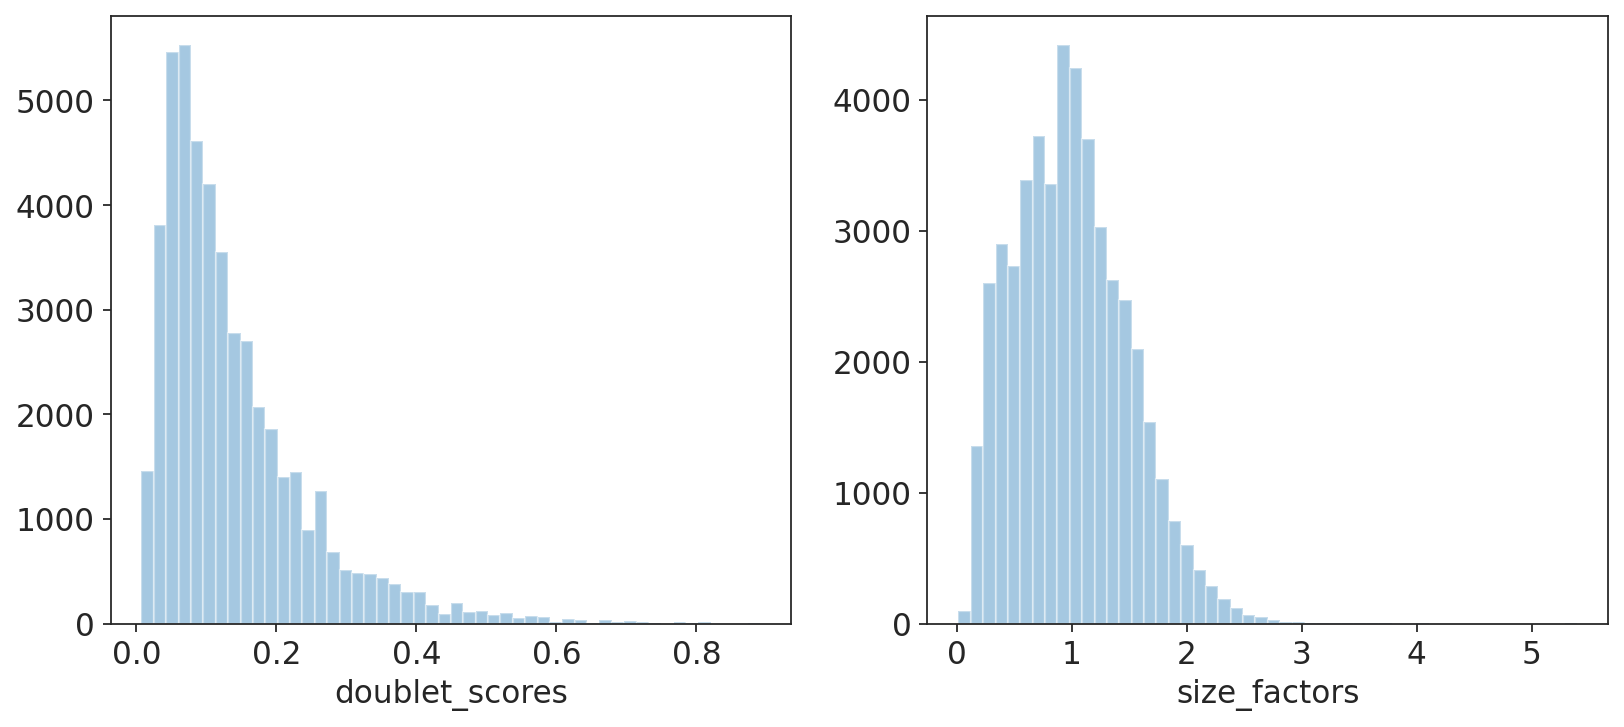

In [16]:
## Add results to adata
adata.obs["size_factors"] = np.nan
size_factors = pd.DataFrame(size_factors, index = adata.obs_names, columns = ["size_factors"])
adata.obs["size_factors"].update(size_factors.size_factors)

## Add souped count layer
from scipy import sparse
adata.layers["unsouped_counts"] = adata.X.copy()
adata.layers["counts"] = sparse.csr_matrix(data)
adata.X = sparse.csr_matrix(data)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axs = axs.ravel()
sb.distplot(adata.obs["doublet_scores"], kde = False, ax = axs[0])
sb.distplot(adata.obs["size_factors"], kde = False, ax = axs[1])
plt.show()

In [17]:
del(adata_pp)
del(data)

## Normalize and Log Transform the ambient corrected counts
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)
adata.X = sparse.csr_matrix(adata.X)

In [18]:
print("unsouped counts\n", type(adata.layers["unsouped_counts"]), "\n", 
      adata.layers["unsouped_counts"][40000:40004, 110:120].todense())
print("souped counts\n", type(adata.layers["counts"]), "\n",  adata.layers["counts"][40000:40004, 110:120].todense())
print("Counts in X\n", type(adata.X), "\n",  adata.X[40000:40004, 110:120].todense())

unsouped counts
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 2. 0.]]
souped counts
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]
Counts in X
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0.         0.         0.         0.         0.         0.
  1.41710218 0.         0.         0.        ]
 [0.         0.         0.63843006 0.         0.         0.
  0.         0.         0.63843006 0.        ]
 [0.         0.         0.50317894 0.         0.         0.
  0.         0.         0.50317894 0.        ]
 [0.         0.         0.46331457 0.         0.         0.
  0.         0.         0.46331457 0.        ]]


### Selection of highly Variable Genes (consider in how many Samples they are variable)

<AxesSubplot:>

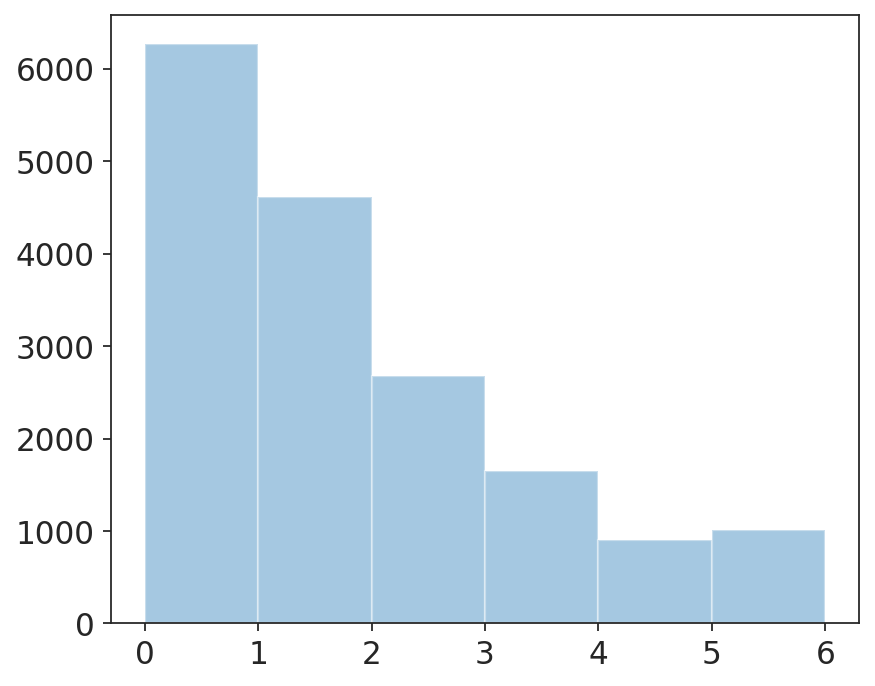

In [19]:
batch = "internal_id"
sc.pp.highly_variable_genes(adata, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                                batch_key = batch, n_top_genes = 4000, n_bins = 20, flavor = "cell_ranger", 
                                subset = False)
vartab = pd.DataFrame(adata.var["highly_variable_nbatches"], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata.obs[batch])))

In [20]:
thresh = 3
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print("%s Genes kept, variable in at least %s samples" %(len(hvgs), thresh))

3560 Genes kept, variable in at least 3 samples


### Remove Cell cycle Genes from list of variable genes

In [22]:
cc_genes = pd.read_table(out_folder + "Macosko_cell_cycle_genes_human.txt", delimiter = "\t")
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()
cc_genes = np.concatenate(cc_genes.values)
cc_genes = np.unique([g for g in cc_genes if isinstance(g, str)])

## Calculate cell cycle Score
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

## Remove cell cycle genes from list
hvgs = np.setdiff1d(hvgs, cc_genes)
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

3442

In [24]:
## Remove mitochondrial and ribosomal genes from list
rbmt_genes = [gene.startswith("MT-") | gene.startswith("RP") for gene in adata.var_names]
adata.var["highly_variable"] = [False if g in adata.var_names[rbmt_genes] else v
                                for g, v in zip(adata.var_names, adata.var["highly_variable"])]
sum(adata.var["highly_variable"])

3426


### Save the pre-processed object

In [25]:
adata.write(object_folder + "GPR87IPF_preprocessed.h5ad")